In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmplu7te92j


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [5]:
# data_dir = "/dataset/"
split_json = "dataset_0.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.12s/it]


image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


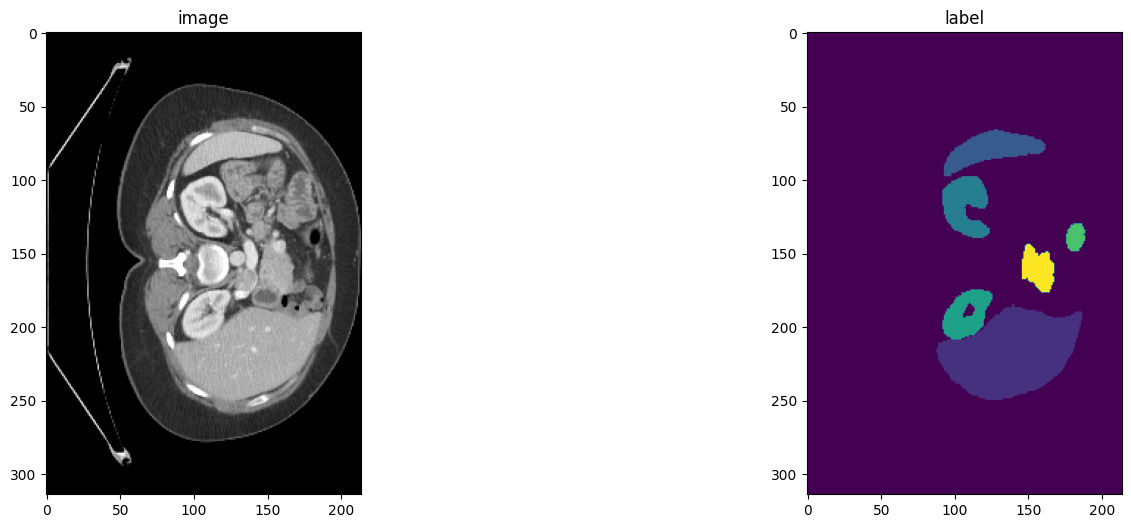

In [7]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [11]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000#25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 25000 Steps) (loss=1.69718):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21/24 [00:11<00:05,  1.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1884324550628662 Current Avg. Dice: 0.1884324550628662


Training (1000 / 25000 Steps) (loss=1.33767):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:10<00:11,  1.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.23040573298931122 Current Avg. Dice: 0.23040573298931122


Training (1500 / 25000 Steps) (loss=1.12095):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:08<00:18,  1.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.27992236614227295 Current Avg. Dice: 0.27992236614227295


Training (2000 / 25000 Steps) (loss=1.09825):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:08<00:26,  1.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.33667615056037903 Current Avg. Dice: 0.33667615056037903


Training (2500 / 25000 Steps) (loss=1.20899):  21%|█████████████████████████▏                                                                                               | 5/24 [00:07<00:39,  2.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.438925176858902 Current Avg. Dice: 0.438925176858902


Training (3000 / 25000 Steps) (loss=1.01484):   4%|█████                                                                                                                    | 1/24 [00:05<02:11,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.438925176858902 Current Avg. Dice: 0.4360520839691162


Training (3500 / 25000 Steps) (loss=1.04984):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:11<00:05,  1.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.49631667137145996 Current Avg. Dice: 0.49631667137145996


Training (4000 / 25000 Steps) (loss=0.98131):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:09<00:11,  1.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5067713856697083 Current Avg. Dice: 0.5067713856697083


Training (4500 / 25000 Steps) (loss=1.07306):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:09<00:18,  1.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5179129242897034 Current Avg. Dice: 0.5179129242897034


Training (5000 / 25000 Steps) (loss=0.86246):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:07<00:26,  1.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5292571187019348 Current Avg. Dice: 0.5292571187019348


Training (5500 / 25000 Steps) (loss=0.90018):  21%|█████████████████████████▏                                                                                               | 5/24 [00:06<00:39,  2.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5324696898460388 Current Avg. Dice: 0.5324696898460388


Training (6000 / 25000 Steps) (loss=1.02472):   4%|█████                                                                                                                    | 1/24 [00:06<02:18,  6.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5324696898460388 Current Avg. Dice: 0.5269931554794312


Training (6500 / 25000 Steps) (loss=0.81348):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:11<00:05,  1.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.540120542049408 Current Avg. Dice: 0.540120542049408


Training (7000 / 25000 Steps) (loss=0.82991):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:09<00:11,  1.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5592007040977478 Current Avg. Dice: 0.5592007040977478


Training (7500 / 25000 Steps) (loss=0.93684):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:09<00:18,  1.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6452502012252808 Current Avg. Dice: 0.6452502012252808


Training (8000 / 25000 Steps) (loss=0.79810):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:07<00:25,  1.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6452502012252808 Current Avg. Dice: 0.6243495345115662


Training (8500 / 25000 Steps) (loss=0.74957):  21%|█████████████████████████▏                                                                                               | 5/24 [00:07<00:39,  2.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.667639970779419 Current Avg. Dice: 0.667639970779419


Training (9000 / 25000 Steps) (loss=0.93741):   4%|█████                                                                                                                    | 1/24 [00:05<02:16,  5.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7032331824302673 Current Avg. Dice: 0.7032331824302673


Training (9500 / 25000 Steps) (loss=0.68461):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:11<00:05,  1.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7235183119773865 Current Avg. Dice: 0.7235183119773865


Training (10000 / 25000 Steps) (loss=0.86969):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:10<00:11,  1.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7789046168327332 Current Avg. Dice: 0.7789046168327332


Training (10500 / 25000 Steps) (loss=0.70800):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:18,  1.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.818172037601471 Current Avg. Dice: 0.818172037601471


Training (11000 / 25000 Steps) (loss=0.79222):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:24,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.818172037601471 Current Avg. Dice: 0.8132448196411133


Training (11500 / 25000 Steps) (loss=0.64703):  21%|█████████████████████████                                                                                               | 5/24 [00:07<00:40,  2.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8272104263305664 Current Avg. Dice: 0.8272104263305664


Training (12000 / 25000 Steps) (loss=0.69240):   4%|█████                                                                                                                   | 1/24 [00:05<02:13,  5.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8272104263305664 Current Avg. Dice: 0.8217382431030273


Training (12500 / 25000 Steps) (loss=0.57237):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:04,  1.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8272104263305664 Current Avg. Dice: 0.822638988494873


Training (13000 / 25000 Steps) (loss=0.68893):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:10<00:11,  1.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8362361788749695 Current Avg. Dice: 0.8362361788749695


Training (13500 / 25000 Steps) (loss=0.74791):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:18,  1.71s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8431046009063721 Current Avg. Dice: 0.8431046009063721


Training (14000 / 25000 Steps) (loss=0.54772):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:25,  1.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8431046009063721 Current Avg. Dice: 0.8260816931724548


Training (14500 / 25000 Steps) (loss=0.51794):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:37,  1.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8431046009063721 Current Avg. Dice: 0.8249166011810303


Training (15000 / 25000 Steps) (loss=0.68419):   4%|█████                                                                                                                   | 1/24 [00:05<02:08,  5.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8431046009063721 Current Avg. Dice: 0.8361870646476746


Training (15500 / 25000 Steps) (loss=0.85800):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:05,  1.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8447561264038086 Current Avg. Dice: 0.8447561264038086


Training (16000 / 25000 Steps) (loss=0.63102):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8447561264038086 Current Avg. Dice: 0.8163114190101624


Training (16500 / 25000 Steps) (loss=0.66329):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:09<00:18,  1.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8449596762657166 Current Avg. Dice: 0.8449596762657166


Training (17000 / 25000 Steps) (loss=0.57929):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:26,  1.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8465330600738525 Current Avg. Dice: 0.8465330600738525


Training (17500 / 25000 Steps) (loss=0.66378):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:37,  1.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8465330600738525 Current Avg. Dice: 0.8449826836585999


Training (18000 / 25000 Steps) (loss=0.59034):   4%|█████                                                                                                                   | 1/24 [00:05<02:05,  5.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8465330600738525 Current Avg. Dice: 0.834794819355011


Training (18500 / 25000 Steps) (loss=0.34530):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:11<00:05,  1.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8508696556091309 Current Avg. Dice: 0.8508696556091309


Training (19000 / 25000 Steps) (loss=0.56604):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8508696556091309 Current Avg. Dice: 0.8370268940925598


Training (19500 / 25000 Steps) (loss=0.79199):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:17,  1.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8508696556091309 Current Avg. Dice: 0.8213715553283691


Training (20000 / 25000 Steps) (loss=0.63284):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:26,  1.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.8624299168586731


Training (20500 / 25000 Steps) (loss=0.64575):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:37,  1.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.840334415435791


Training (21000 / 25000 Steps) (loss=0.35735):   4%|█████                                                                                                                   | 1/24 [00:05<02:13,  5.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.8248351216316223


Training (21500 / 25000 Steps) (loss=0.56817):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:04,  1.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.844044029712677


Training (22000 / 25000 Steps) (loss=0.60772):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.8392031788825989


Training (22500 / 25000 Steps) (loss=0.79988):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:17,  1.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.8534398078918457


Training (23000 / 25000 Steps) (loss=0.74351):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:25,  1.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.8363642692565918


Training (23500 / 25000 Steps) (loss=0.60448):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:37,  1.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.857400119304657


Training (24000 / 25000 Steps) (loss=0.59842):   4%|█████                                                                                                                   | 1/24 [00:05<02:09,  5.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.8599712252616882


Training (24500 / 25000 Steps) (loss=0.68906):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:04,  1.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.8587269186973572


Training (25000 / 25000 Steps) (loss=0.69412):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8624299168586731 Current Avg. Dice: 0.8407033085823059


Training (25007 / 25000 Steps) (loss=0.44850): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.04it/s]


<All keys matched successfully>

In [12]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8624 at iteration: 20000


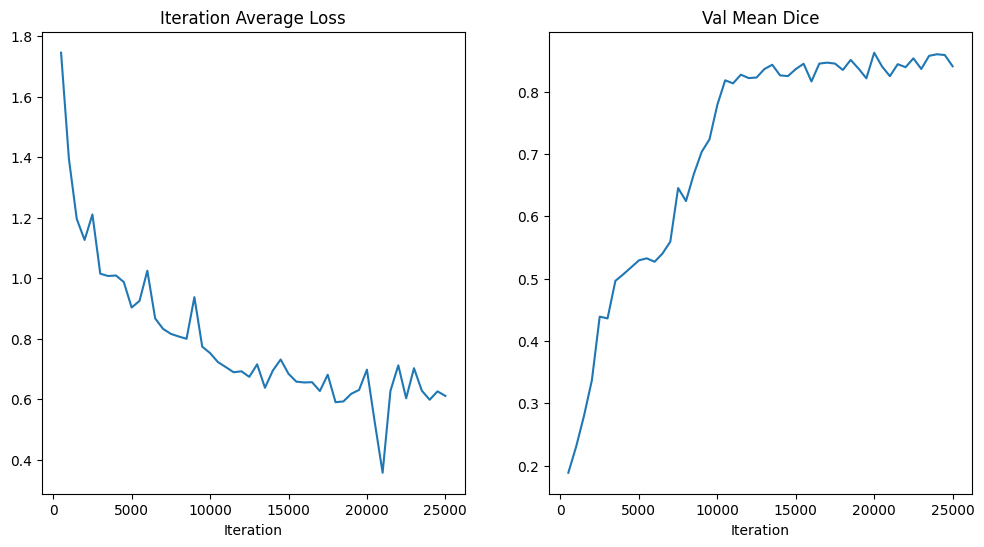

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

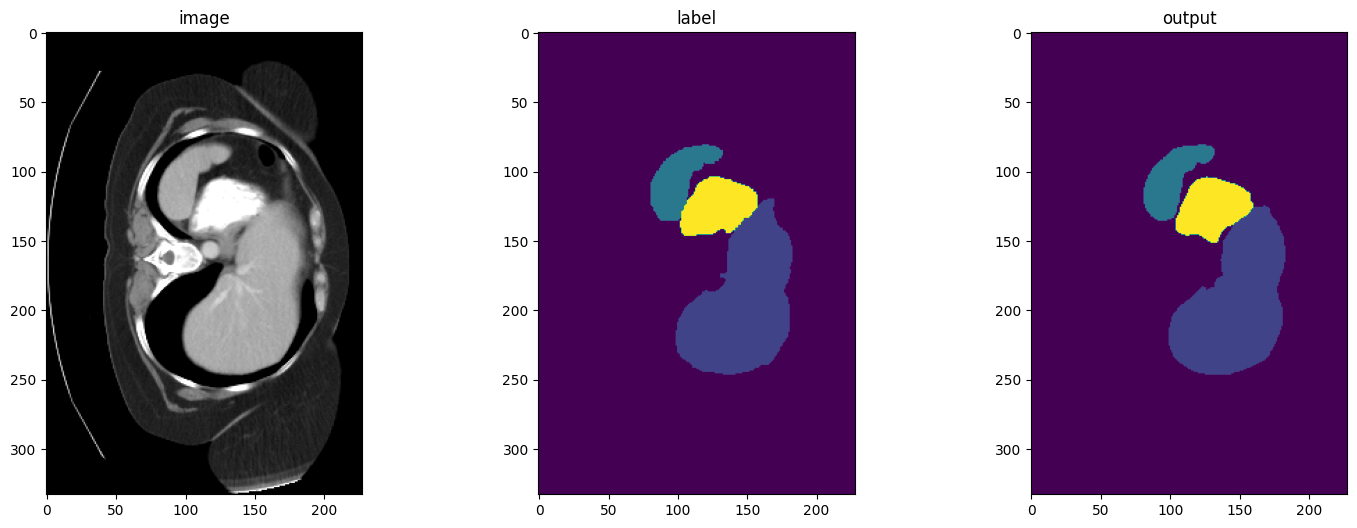

In [14]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()